In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist

import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
train_loader, test_loader = mnist()

In [57]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [69]:
def train(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in models.items()])
        print(line + losses)

In [73]:
def test(models, log=None):
    test_size = len(test_loader.dataset)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in test_loader:
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [135]:
models = {'softmax' : Net(), 'log_softmax' : Net(True)}
test_log = {k: [] for k in models}

epochs = 100
for epoch in range(1, epochs+1):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses softmax: 2.326781 log_softmax: 2.265284
Train Epoch: 1 [10000/60000 (17%)]	Losses softmax: 0.237820 log_softmax: 0.241340
Train Epoch: 1 [20000/60000 (33%)]	Losses softmax: 0.231649 log_softmax: 0.217126
Train Epoch: 1 [30000/60000 (50%)]	Losses softmax: 0.121032 log_softmax: 0.154159
Train Epoch: 1 [40000/60000 (67%)]	Losses softmax: 0.121187 log_softmax: 0.138780
Train Epoch: 1 [50000/60000 (83%)]	Losses softmax: 0.099783 log_softmax: 0.123326
Train Epoch: 1 [60000/60000 (100%)]	Losses softmax: 0.205731 log_softmax: 0.293933
Test set:
softmax: Loss: 0.1168	Accuracy: 9653.0/10000 (97%)
log_softmax: Loss: 0.1154	Accuracy: 9646.0/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Losses softmax: 0.108391 log_softmax: 0.134507
Train Epoch: 2 [10000/60000 (17%)]	Losses softmax: 0.065974 log_softmax: 0.070084
Train Epoch: 2 [20000/60000 (33%)]	Losses softmax: 0.113125 log_softmax: 0.233639
Train Epoch: 2 [30000/60000 (50%)]	Losses softmax: 0.084615 log_softmax:

Train Epoch: 13 [10000/60000 (17%)]	Losses softmax: 0.102025 log_softmax: 0.086295
Train Epoch: 13 [20000/60000 (33%)]	Losses softmax: 0.001988 log_softmax: 0.001860
Train Epoch: 13 [30000/60000 (50%)]	Losses softmax: 0.003234 log_softmax: 0.001894
Train Epoch: 13 [40000/60000 (67%)]	Losses softmax: 0.003544 log_softmax: 0.001554
Train Epoch: 13 [50000/60000 (83%)]	Losses softmax: 0.005321 log_softmax: 0.003049
Train Epoch: 13 [60000/60000 (100%)]	Losses softmax: 0.002154 log_softmax: 0.001109
Test set:
softmax: Loss: 0.0677	Accuracy: 9798.0/10000 (98%)
log_softmax: Loss: 0.0733	Accuracy: 9786.0/10000 (98%)

Train Epoch: 14 [0/60000 (0%)]	Losses softmax: 0.001663 log_softmax: 0.004021
Train Epoch: 14 [10000/60000 (17%)]	Losses softmax: 0.001169 log_softmax: 0.002376
Train Epoch: 14 [20000/60000 (33%)]	Losses softmax: 0.001612 log_softmax: 0.001915
Train Epoch: 14 [30000/60000 (50%)]	Losses softmax: 0.002921 log_softmax: 0.002683
Train Epoch: 14 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 25 [10000/60000 (17%)]	Losses softmax: 0.000715 log_softmax: 0.000665
Train Epoch: 25 [20000/60000 (33%)]	Losses softmax: 0.000193 log_softmax: 0.000391
Train Epoch: 25 [30000/60000 (50%)]	Losses softmax: 0.001532 log_softmax: 0.001082
Train Epoch: 25 [40000/60000 (67%)]	Losses softmax: 0.001182 log_softmax: 0.000707
Train Epoch: 25 [50000/60000 (83%)]	Losses softmax: 0.000825 log_softmax: 0.000701
Train Epoch: 25 [60000/60000 (100%)]	Losses softmax: 0.002076 log_softmax: 0.002738
Test set:
softmax: Loss: 0.0718	Accuracy: 9803.0/10000 (98%)
log_softmax: Loss: 0.0771	Accuracy: 9792.0/10000 (98%)

Train Epoch: 26 [0/60000 (0%)]	Losses softmax: 0.000321 log_softmax: 0.000390
Train Epoch: 26 [10000/60000 (17%)]	Losses softmax: 0.000859 log_softmax: 0.000961
Train Epoch: 26 [20000/60000 (33%)]	Losses softmax: 0.000352 log_softmax: 0.000381
Train Epoch: 26 [30000/60000 (50%)]	Losses softmax: 0.000766 log_softmax: 0.001223
Train Epoch: 26 [40000/60000 (67%)]	Losses softmax: 0.001

Train Epoch: 37 [10000/60000 (17%)]	Losses softmax: 0.000884 log_softmax: 0.001226
Train Epoch: 37 [20000/60000 (33%)]	Losses softmax: 0.000170 log_softmax: 0.000470
Train Epoch: 37 [30000/60000 (50%)]	Losses softmax: 0.000191 log_softmax: 0.000225
Train Epoch: 37 [40000/60000 (67%)]	Losses softmax: 0.000950 log_softmax: 0.001021
Train Epoch: 37 [50000/60000 (83%)]	Losses softmax: 0.000169 log_softmax: 0.000601
Train Epoch: 37 [60000/60000 (100%)]	Losses softmax: 0.000560 log_softmax: 0.000569
Test set:
softmax: Loss: 0.0743	Accuracy: 9805.0/10000 (98%)
log_softmax: Loss: 0.0801	Accuracy: 9793.0/10000 (98%)

Train Epoch: 38 [0/60000 (0%)]	Losses softmax: 0.000307 log_softmax: 0.000531
Train Epoch: 38 [10000/60000 (17%)]	Losses softmax: 0.000289 log_softmax: 0.000506
Train Epoch: 38 [20000/60000 (33%)]	Losses softmax: 0.000727 log_softmax: 0.001049
Train Epoch: 38 [30000/60000 (50%)]	Losses softmax: 0.000643 log_softmax: 0.000964
Train Epoch: 38 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 49 [10000/60000 (17%)]	Losses softmax: 0.001340 log_softmax: 0.000640
Train Epoch: 49 [20000/60000 (33%)]	Losses softmax: 0.000712 log_softmax: 0.000452
Train Epoch: 49 [30000/60000 (50%)]	Losses softmax: 0.000215 log_softmax: 0.000086
Train Epoch: 49 [40000/60000 (67%)]	Losses softmax: 0.000328 log_softmax: 0.000164
Train Epoch: 49 [50000/60000 (83%)]	Losses softmax: 0.000920 log_softmax: 0.000774
Train Epoch: 49 [60000/60000 (100%)]	Losses softmax: 0.000225 log_softmax: 0.000318
Test set:
softmax: Loss: 0.0767	Accuracy: 9801.0/10000 (98%)
log_softmax: Loss: 0.0824	Accuracy: 9792.0/10000 (98%)

Train Epoch: 50 [0/60000 (0%)]	Losses softmax: 0.000315 log_softmax: 0.000188
Train Epoch: 50 [10000/60000 (17%)]	Losses softmax: 0.000537 log_softmax: 0.000295
Train Epoch: 50 [20000/60000 (33%)]	Losses softmax: 0.000221 log_softmax: 0.000258
Train Epoch: 50 [30000/60000 (50%)]	Losses softmax: 0.000465 log_softmax: 0.000248
Train Epoch: 50 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 61 [10000/60000 (17%)]	Losses softmax: 0.000114 log_softmax: 0.000132
Train Epoch: 61 [20000/60000 (33%)]	Losses softmax: 0.000640 log_softmax: 0.000871
Train Epoch: 61 [30000/60000 (50%)]	Losses softmax: 0.000253 log_softmax: 0.000212
Train Epoch: 61 [40000/60000 (67%)]	Losses softmax: 0.000345 log_softmax: 0.000463
Train Epoch: 61 [50000/60000 (83%)]	Losses softmax: 0.000280 log_softmax: 0.000078
Train Epoch: 61 [60000/60000 (100%)]	Losses softmax: 0.000145 log_softmax: 0.000160
Test set:
softmax: Loss: 0.0781	Accuracy: 9805.0/10000 (98%)
log_softmax: Loss: 0.0839	Accuracy: 9793.0/10000 (98%)

Train Epoch: 62 [0/60000 (0%)]	Losses softmax: 0.000291 log_softmax: 0.000188
Train Epoch: 62 [10000/60000 (17%)]	Losses softmax: 0.000138 log_softmax: 0.000302
Train Epoch: 62 [20000/60000 (33%)]	Losses softmax: 0.000443 log_softmax: 0.000436
Train Epoch: 62 [30000/60000 (50%)]	Losses softmax: 0.000342 log_softmax: 0.000787
Train Epoch: 62 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 73 [10000/60000 (17%)]	Losses softmax: 0.000038 log_softmax: 0.000080
Train Epoch: 73 [20000/60000 (33%)]	Losses softmax: 0.000211 log_softmax: 0.000176
Train Epoch: 73 [30000/60000 (50%)]	Losses softmax: 0.000195 log_softmax: 0.000093
Train Epoch: 73 [40000/60000 (67%)]	Losses softmax: 0.000098 log_softmax: 0.000232
Train Epoch: 73 [50000/60000 (83%)]	Losses softmax: 0.000536 log_softmax: 0.000532
Train Epoch: 73 [60000/60000 (100%)]	Losses softmax: 0.000314 log_softmax: 0.000332
Test set:
softmax: Loss: 0.0793	Accuracy: 9802.0/10000 (98%)
log_softmax: Loss: 0.0853	Accuracy: 9791.0/10000 (98%)

Train Epoch: 74 [0/60000 (0%)]	Losses softmax: 0.000689 log_softmax: 0.000316
Train Epoch: 74 [10000/60000 (17%)]	Losses softmax: 0.000296 log_softmax: 0.000356
Train Epoch: 74 [20000/60000 (33%)]	Losses softmax: 0.000190 log_softmax: 0.000360
Train Epoch: 74 [30000/60000 (50%)]	Losses softmax: 0.000128 log_softmax: 0.000121
Train Epoch: 74 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 85 [10000/60000 (17%)]	Losses softmax: 0.000130 log_softmax: 0.000143
Train Epoch: 85 [20000/60000 (33%)]	Losses softmax: 0.000109 log_softmax: 0.000158
Train Epoch: 85 [30000/60000 (50%)]	Losses softmax: 0.000703 log_softmax: 0.000607
Train Epoch: 85 [40000/60000 (67%)]	Losses softmax: 0.000059 log_softmax: 0.000058
Train Epoch: 85 [50000/60000 (83%)]	Losses softmax: 0.000232 log_softmax: 0.000170
Train Epoch: 85 [60000/60000 (100%)]	Losses softmax: 0.000253 log_softmax: 0.000089
Test set:
softmax: Loss: 0.0804	Accuracy: 9806.0/10000 (98%)
log_softmax: Loss: 0.0864	Accuracy: 9795.0/10000 (98%)

Train Epoch: 86 [0/60000 (0%)]	Losses softmax: 0.000292 log_softmax: 0.000240
Train Epoch: 86 [10000/60000 (17%)]	Losses softmax: 0.000226 log_softmax: 0.000240
Train Epoch: 86 [20000/60000 (33%)]	Losses softmax: 0.000183 log_softmax: 0.000234
Train Epoch: 86 [30000/60000 (50%)]	Losses softmax: 0.000300 log_softmax: 0.000443
Train Epoch: 86 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 97 [10000/60000 (17%)]	Losses softmax: 0.000124 log_softmax: 0.000154
Train Epoch: 97 [20000/60000 (33%)]	Losses softmax: 0.000078 log_softmax: 0.000097
Train Epoch: 97 [30000/60000 (50%)]	Losses softmax: 0.000330 log_softmax: 0.000365
Train Epoch: 97 [40000/60000 (67%)]	Losses softmax: 0.000035 log_softmax: 0.000049
Train Epoch: 97 [50000/60000 (83%)]	Losses softmax: 0.000182 log_softmax: 0.000136
Train Epoch: 97 [60000/60000 (100%)]	Losses softmax: 0.000084 log_softmax: 0.000079
Test set:
softmax: Loss: 0.0813	Accuracy: 9804.0/10000 (98%)
log_softmax: Loss: 0.0874	Accuracy: 9796.0/10000 (98%)

Train Epoch: 98 [0/60000 (0%)]	Losses softmax: 0.000055 log_softmax: 0.000106
Train Epoch: 98 [10000/60000 (17%)]	Losses softmax: 0.000146 log_softmax: 0.000193
Train Epoch: 98 [20000/60000 (33%)]	Losses softmax: 0.000416 log_softmax: 0.000407
Train Epoch: 98 [30000/60000 (50%)]	Losses softmax: 0.000178 log_softmax: 0.000099
Train Epoch: 98 [40000/60000 (67%)]	Losses softmax: 0.000

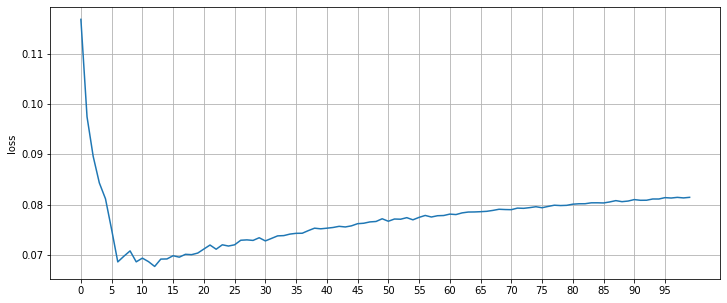

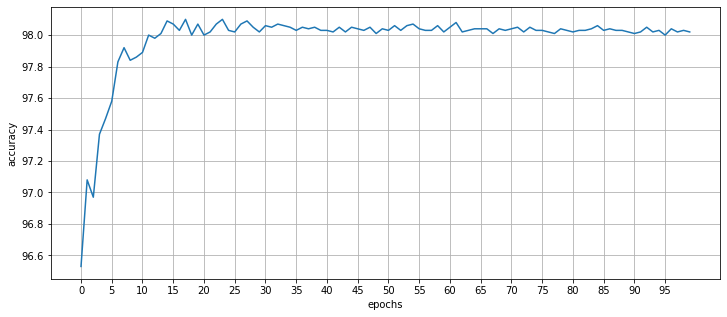

In [167]:
test_loss_softmax = [i[0] for i in test_log['softmax']]
test_acc_softmax = [i[1] for i in test_log['softmax']]
test_loss_log_softmax = [i[0] for i in test_log['log_softmax']]
test_acc_log_softmax = [i[1] for i in test_log['log_softmax']]

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_loss_softmax)
plt.xticks(range(0, epochs, 5))
plt.ylabel('loss')
plt.grid()

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_acc_softmax)
plt.xlabel('epochs')
plt.xticks(range(0, epochs, 5))
plt.ylabel('accuracy')
plt.grid()

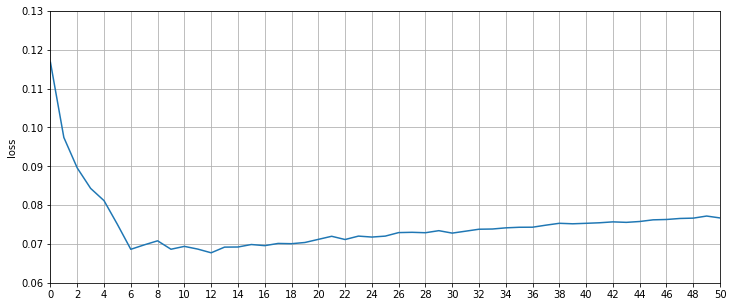

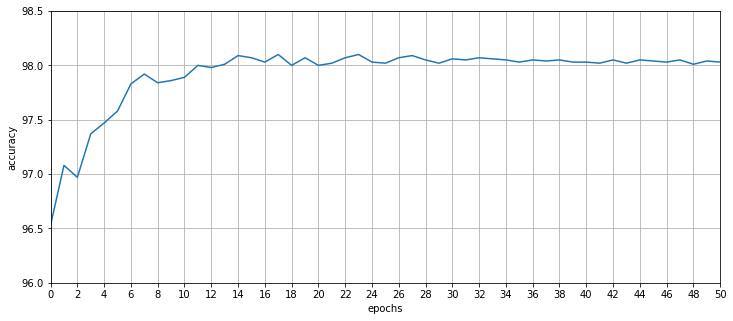

In [170]:
test_loss_softmax = [i[0] for i in test_log['softmax']]
test_acc_softmax = [i[1] for i in test_log['softmax']]
test_loss_log_softmax = [i[0] for i in test_log['log_softmax']]
test_acc_log_softmax = [i[1] for i in test_log['log_softmax']]

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_loss_softmax)
plt.xticks(range(0, epochs, 2))
plt.xlim((0, 50))
plt.ylim((0.06, 0.13))
plt.ylabel('loss')
plt.grid()

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_acc_softmax)
plt.xlabel('epochs')
plt.xticks(range(0, epochs, 2))
plt.xlim((0, 50))
plt.ylim((96, 98.5))
plt.ylabel('accuracy')
plt.grid()

In [173]:
test_loss_softmax[49]

0.07719257820115599